# NPQ model

Model of non-photochemical quenching in plants implementded in modelbase version 1.0 (see Matuszyńska, A., Heidari, S., Jahns, P., Ebenhöh, O., 2016. A mathematical model of non-photochemical quenching to study short-term light memory in plants. Biochimica et Biophysica Acta (BBA) - Bioenergetics 1857, 1860–1869. https://doi.org/10.1016/j.bbabio.2016.09.003)
 

In [1]:
#!conda list

## Import packages

In [2]:
import numpy as np
from modelbase.ode import Model, Simulator

Could not find GLIMDA


## Parameter set

In [3]:
#Comments from original implementation by Matuszynska et al 2016

pars = {
            
    #Pool sizes 
    'PSIItot': 2.5,  # [mmol/molChl] total concentration of PSII        
    'PQtot': 20,     # [mmol/molChl]      
    'APtot': 50,     # [mmol/molChl] Bionumbers ~2.55mM (=81mmol/molChl)      
    'PsbStot': 1,    # [relative] LHCs that get phosphorylated and protonated       
    'Xtot': 1,       # [relative] xanthophylls     
    'O2ex': 8,       # external oxygen, kept constant, corresponds to 250 microM, corr. to 20%      
    'Pi': 0.01,             
            
    #Rate constants and key parameters
    'kCytb6f': 0.104,           # a rough estimate of the transfer from PQ to cyt that is equal to ~ 10ms
                                # [1/s*(mmol/(s*m^2))] - gets multiplied by light to determine rate
    'kActATPase': 0.01,        # paramter relating the rate constant of activation of the ATPase in the light
    'kDeactATPase': 0.002,     # paramter relating the deactivation of the ATPase at night
    'kATPsynthase': 20.,
    'kATPconsumption': 10.,
    'kPQred': 250.,            # [1/(s*(mmol/molChl))]
    'kH': 5e9,
    'kF': 6.25e8,              # fluorescence 16ns
    'kP': 5e9,                 # original 5e9 (charge separation limiting step ~ 200ps) - made this faster for higher Fs fluorescence
    'kPTOX': 0.01,             # ~ 5 electrons / seconds. This gives a bit more (~20)
    'pHstroma': 7.8,           # [1/s] leakage rate
    'kleak': 1000,
    'bH': 100,                 # proton buffer: ratio total / free protons
    'HPR': 14./3.,
            
    #Parameter associated with xanthophyll cycle
    'kDeepoxV': 0.0024,
    'kEpoxZ': 0.00024,   # 6.e-4,  #converted to [1/s]
    'KphSatZ': 5.8,      # [-] half-saturation pH value for activity de-epoxidase, highest activity at ~pH 5.8
    'nHX': 5.,           # [-] hill-coefficient for activity of de-epoxidase
    'Kzsat': 0.12,       # [-], half-saturation constant (relative conc. of Z) for quenching of Z
            
    #Parameter associated with PsbS protonation
    'nHL': 3,
    'kDeprot': 0.0096,
    'kProt': 0.0096,
    'KphSatLHC': 5.8,
            
    #Fitted quencher contribution factors
    'gamma0': 0.1,   # slow quenching of Vx present despite lack of protonation
    'gamma1': 0.25,  # fast quenching present due to the protonation
    'gamma2': 0.6,   # slow quenching of Zx present despite lack of protonation
    'gamma3': 0.15,  # fastest possible quenching
            
    #Physical constants
    'F': 96.485,  # Faraday constant
    'R': 8.3e-3,  # universal gas constant
    'T': 298,     # Temperature in K - for now assumed to be constant at 25 C
            
    #Standard potentials and DG0ATP
    'E0QAQAm': -0.140,
    'E0PQPQH2': 0.354,
    'E0PCPCm': 0.380,
    'DG0ATP': 30.6,  # 30.6kJ/mol / RT
            
    #PFD
    'PFD': 100

            }

## pH and cpfd functions

In [4]:
def pH(H):
    return -np.log10(H*2.5e-4)

def pHinv(pH):
    return 4e3 * 10 ** -pH

def cpfdf(PFD):
    """cpfd function for Arabidopsis thaliana"""
    cpfd =  0.0005833 * PFD**2 + 0.2667 * PFD + 187.5
    return cpfd

## Model initialization and compounds

In [5]:
# define the basic model 
M16model = Model(pars)

# add compounds 
M16model.add_compounds([
    "P", # reduced Plastoquinone
    "H", # luminal Protons
    "E", # ATPactivity
    "A", # ATP
    "Pr", # fraction of non-protonated PsbS (notation from doctoral thesis Matuszynska 2016)
    "V" # fraction of Violaxanthin
    ])

## Derived parameters

In [ ]:
M16model.add_derived_parameter(
    parameter_name="RT", function=lambda r, t: r * t, parameters=["R", "T"])

def _KeqQAPQ(F, E0QAQAm, E0PQPQH2, pHstroma, RT):
    DG1 =  -F*E0QAQAm
    DG2 = -2*F*E0PQPQH2 + 2*pHstroma * np.log(10) * RT
    DG0 = -2*DG1 + DG2
    Keq = np.exp(-DG0/RT)
    return Keq

M16model.add_derived_parameter(
    parameter_name = "KeqQAPQ", function=_KeqQAPQ, parameters=["F", "E0QAQAm", "E0PQPQH2", "pHstroma", "RT"])

## Auxiliary functions

In [7]:
def ps2states(P, Q, light, PQtot, kPQred, KeqQAPQ, kH, kF, kP, PSIItot):
    """Calculates the states of photosystem II
    
    accepts:
    P: reduced fraction of PQ pool (PQH2)
    Q: Quencher
    
    returns:
    B: array of PSII states
    """
    
    Bs = []
    Pox = PQtot - P
    b0 = (light + kPQred*P/KeqQAPQ)
    b1 = (kH * Q + kF)
    b2 = kH * Q + kF + kP
    
    for Pox,b0,b1,b2 in zip(Pox,b0,b1,b2):
        A = np.array([
        [-b0,        b1,         kPQred*Pox,                0], #B0
        [light,     -b2,         0,                         0], #B1
        [0,          0,          light,                   -b1], #B3
        [1,          1,          1,                         1]
        ])
        
        b = np.array([0,0,0,PSIItot])
        B0,B1,B2,B3 = np.linalg.solve(A,b)
        Bs.append([B0, B1, B2, B3])
    return np.array(Bs).T


def Keqcytb6f(H, F, E0PQPQH2, RT, E0PCPCm, pHstroma):
    """Equilibriu constant of Cytochrome b6f"""
    DG1 = -2*F*E0PQPQH2 + 2 * RT * np.log(10) * pH(H)
    DG2 = -F*E0PCPCm
    DG3 = RT*np.log(10)*(pHstroma - pH(H))
    DG = -DG1 + 2*DG2 + 2*DG3
    Keq = np.exp(-DG/RT)
    return Keq
    
    
def KeqATPsyn(H, DG0ATP, pHstroma, RT, Pi):
    """Equilibrium constant of ATP synthase. For more
    information see Matuszynska et al 2016 or Ebenhöh et al. 2011,2014
    """
    DG = DG0ATP - np.log(10) * (pHstroma-pH(H)) * (14/3)  * RT
    Keq = Pi * np.exp(-DG/RT) 
    return Keq

def Fluorescence(P, Q, B0, B2, light, PQtot, kPQred, KeqQAPQ, kH, kF, kP, PSIItot):
    """Fluorescence function"""
    Fluo =  kF/(kH*Q+kF+kP) * B0 + kF/(kH*Q+kF) * B2
    return Fluo

def Quencher(Pr, V, Xtot, PsbStot, Kzsat, gamma0, gamma1, gamma2, gamma3):
    """Quencher mechanism
    
    accepts: 
    Pr: fraction of non-protonated PsbS protein
    V: fraction of Violaxanthin
    """
    Z = Xtot - V
    P = PsbStot - Pr
    Zs = Z/(Z +  Kzsat)
        
    Q = gamma0 * (1-Zs) * Pr \
    + gamma1 * (1-Zs) * P \
    + gamma2 * Zs * P \
    + gamma3 * Zs * Pr
    return Q

## Conserved quantities

In [8]:
def pqmoiety(P, PQtot):
    return [PQtot - P]

def atpmoiety(A, APtot):
    return [APtot - A]

def psbsmoiety(Pr, PsbStot):
    return [PsbStot - Pr]

def xcycmoiety(V, Xtot):
    return [Xtot - V]

# Rate equations

In [9]:
def vps2(B1, light, PQtot, kPQred, KeqQAPQ, kH, kF, kP, PSIItot): 
    """Reduction of PQ due to ps2"""
    v = kP * 0.5 * B1
    return v

    
    
def vPQox(P, H, light, kCytb6f, kPTOX, O2ex, PQtot, F, E0PQPQH2, RT, E0PCPCm, pHstroma):
    """Oxidation of the PQ pool through cytochrome and PTOX"""
    kPFD = kCytb6f * light
    kPTOX = kPTOX * O2ex 
    Keq = Keqcytb6f(H, F, E0PQPQH2, RT, E0PCPCm, pHstroma)
    a1 = kPFD * Keq/ (Keq + 1)  
    a2 = kPFD/(Keq + 1)
    v = (a1 + kPTOX) * P - a2 * (PQtot - P)
    return v
    
    
def vATPsynthase(A, H, E, kATPsynthase, DG0ATP, pHstroma, RT, Pi, APtot):
    """Production of ATP by ATPsynthase"""
    v = E * kATPsynthase * (APtot - A - A/KeqATPsyn(H, DG0ATP, pHstroma, RT, Pi))
    return v
    
    
def vATPactivity(E, light,  kActATPase,  kDeactATPase):
    """Activation of ATPsynthase by light"""
    switch = light > 0
    v = kActATPase * switch * (1 - E) - kDeactATPase * (1-switch) * E
    return v
    
    
def vLeak(H, kleak, pHstroma):
    """Transmembrane proton leak"""
    v = kleak * (H - pHinv(pHstroma))
    return v
    
    
def vATPcons(A, kATPconsumption):
    """ATP consuming reaction"""
    v = kATPconsumption * A
    return v
    
    
def vXcyc(V, H, nHX, KphSatZ, kDeepoxV, kEpoxZ, Xtot):
    """Xanthophyll cycle"""
    a = H**nHX / (H**nHX + pHinv(KphSatZ)**nHX)
    v = kDeepoxV * a * V - kEpoxZ * (Xtot - V)
    return v
    
    
def vPsbSP(Pr, H, nHL, KphSatLHC, kProt, kDeprot, PsbStot):
    """Protonation of PsbS protein"""
    a = H**nHL / (H**nHL + pHinv(KphSatLHC)**nHL)
    v = kProt * a * Pr - kDeprot * (PsbStot - Pr)
    return v

## Algebraic modules

In [10]:
M16model.add_algebraic_module(
    module_name = "P_am",
    function = pqmoiety,
    compounds = ["P"],
    derived_compounds = ["Pox"],
    parameters = ["PQtot"])


M16model.add_algebraic_module(
    module_name = "A_am",
    function = atpmoiety,
    compounds = ["A"],
    derived_compounds = ["ADP"],
    parameters = ["APtot"])


M16model.add_algebraic_module(
    module_name = "PsbS_am",
    function = psbsmoiety,
    compounds = ["Pr"],
    derived_compounds = ["Pnr"],
    parameters = ["PsbStot"])


M16model.add_algebraic_module(
    module_name = "X_am",
    function = xcycmoiety,
    compounds = ["V"],
    derived_compounds = ["Z"],
    parameters = ["Xtot"])


M16model.add_algebraic_module(
    module_name = "Quencher",
    function = Quencher,
    compounds = ["Pr", "V"],
    derived_compounds = ["Q"],
    parameters = ["Xtot", "PsbStot", "Kzsat",
                  "gamma0", "gamma1", "gamma2",
                  "gamma3"])


M16model.add_algebraic_module(
    module_name = 'PSIIstates',
    function = ps2states,
    compounds = ["P", "Q"],
    derived_compounds = ["B0", "B1", "B2", "B3"],
    parameters = ["PFD", "PQtot", "kPQred",
                  "KeqQAPQ", "kH", "kF", "kP", "PSIItot"])


M16model.add_algebraic_module(
    module_name = "Fluorescence",
    function = Fluorescence,
    compounds = ["P", "Q", "B0", "B2"],
    derived_compounds = ["Fluo"],
    parameters = ['PFD', 'PQtot', 'kPQred', 'KeqQAPQ',
                  'kH', 'kF', 'kP', 'PSIItot'])

# Mock module to get Light vector over all simulated time points
#M16model.add_algebraic_module(
#    module_name = "L",
#    function = lambda X, PFD: PFD ,
#    compounds = ["P"],
#    derived_compounds = ["L"],
#    parameters = ['PFD'])

## Add reactions

In [11]:
M16model.add_reaction(
        rate_name = "vps2",
        function = vps2,
        dynamic_variables=["B1"],
        stoichiometry = {"P":1,"H":2/pars["bH"]},
        parameters = ["PFD","PQtot","kPQred", "KeqQAPQ",
                      "kH", "kF", "kP", "PSIItot"])


M16model.add_reaction(
        rate_name = "vPQox",
        function = vPQox,
        dynamic_variables = ['P','H'],
        stoichiometry = {"P":-1,"H":4/pars["bH"]},
        parameters = ["PFD", "kCytb6f", "kPTOX", "O2ex",
                          "PQtot", "F", "E0PQPQH2", "RT", "E0PCPCm",
                          "pHstroma"])

    
M16model.add_reaction(
        rate_name = "vATPsynthase",
        function = vATPsynthase,
        dynamic_variables = ["A","H","E"],
        stoichiometry = {"A":1, "H": (-14/3)/pars["bH"]},
        parameters = ["kATPsynthase", "DG0ATP", "pHstroma",
                      "RT", "Pi", "APtot"])
    
    
M16model.add_reaction(
        rate_name = "vATPactivity",
        function = vATPactivity,
        dynamic_variables = ["E"],
        stoichiometry = {"E":1},
        parameters = ["PFD",  "kActATPase",  "kDeactATPase"])


M16model.add_reaction(
        rate_name = "vLeak",
        function  = vLeak,
        stoichiometry = {"H": -1/pars["bH"]},
        parameters = ["kleak", "pHstroma"])


M16model.add_reaction(
        rate_name = "vATPcons",
        function = vATPcons,
        stoichiometry = {"A":-1},
        parameters = ["kATPconsumption"])


M16model.add_reaction(
        rate_name = "vXcyc",
        function = vXcyc,
        dynamic_variables = ['V','H'],
        stoichiometry = {"V": -1},
        parameters = ["nHX", "KphSatZ", "kDeepoxV",
                      "kEpoxZ", "Xtot"])


M16model.add_reaction(
        rate_name = "vPsbSP",
        function = vPsbSP,
        dynamic_variables = ["Pr", "H"],
        stoichiometry = {"Pr":-1},
        parameters = ["nHL", "KphSatLHC", "kProt",
                      "kDeprot", "PsbStot"])

In [12]:
M16model.get_stoichiometric_df()

,vATPactivity,vATPcons,vATPsynthase,vLeak,vPQox,vPsbSP,vXcyc,vps2
A,0.0,-1.0,1.000000,0.00,0.00,0.0,0.0,0.00
E,1.0,0.0,0.000000,0.00,0.00,0.0,0.0,0.00
H,0.0,0.0,-0.046667,-0.01,0.04,0.0,0.0,0.02
P,0.0,0.0,0.000000,0.00,-1.00,0.0,0.0,1.00
Pr,0.0,0.0,0.000000,0.00,0.00,-1.0,0.0,0.00
V,0.0,0.0,0.000000,0.00,0.00,0.0,-1.0,0.00


# Test: reproduce figure 4 from Matuszynka et al. 2016

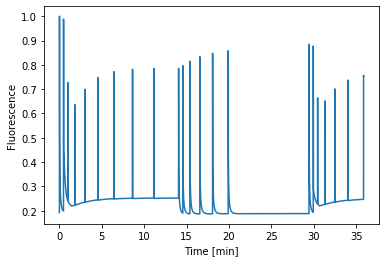

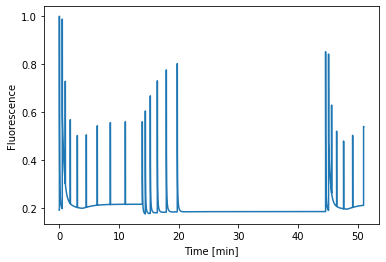

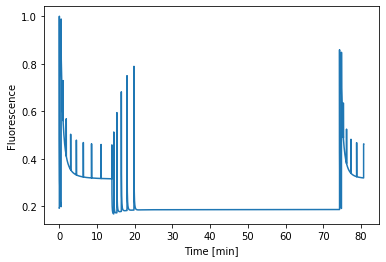

In [13]:
import matplotlib.pyplot as plt
from matplotlib import patches
    
y0d =  {"P": 0, "H": 6.32975752e-05, "E": 0, "A": 25.0, "Pr": 1, "V": 1}
    
#Function for PAM experiment
def changingLight(model, y0d, lights, interval):
    s = Simulator(model)
    s.initialise(y0d)
    dt = 0
    for i in range(len(interval)):
        s.update_parameter('PFD', lights[i])
        dt += interval[i]
        s.simulate(dt, **{"rtol":1e-16,"atol":1e-6, "maxnef": 20, "maxncf":10})
    return s
    
    
##########################################################################
# REPRODUCE FIGURE 4 MATUSZYNSKA 4
##########################################################################

#Value of actinic light was calculated using the cpdf function
    
tprot = np.array([  1.        ,   0.8       ,  27.86666667,   0.8       ,
                  29.86666667,   0.8       ,  49.53333333,   0.8       ,
                  70.2       ,   0.8       ,  91.2       ,   0.8       ,
                  110.86666667,   0.8       , 131.2       ,   0.8       ,
                  151.53333333,   0.8       , 172.53333333,   0.8       ,
                  29.2       ,   0.8       ,  49.2       ,   0.8       ,
                  69.53333333,   0.8       ,  89.2       ,   0.8       ,
                  109.53333333,   0.8       , 570.53333333,   0.8       ,
                  29.2       ,   0.8       ,  29.86666667,   0.8       ,
                  49.86666667,   0.8       ,  70.53333333,   0.8       ,
                  90.53333333,   0.8       , 110.86666667,   0.8       ])
    
ProtPFDs = np.array([   0.   , 5000.   ,    0.   , 5000.   ,  220.003, 5000.   ,
                     220.003, 5000.   ,  220.003, 5000.   ,  220.003, 5000.   ,
                     220.003, 5000.   ,  220.003, 5000.   ,  220.003, 5000.   ,
                     220.003, 5000.   ,    0.   , 5000.   ,    0.   , 5000.   ,
                     0.   , 5000.   ,    0.   , 5000.   ,    0.   , 5000.   ,
                     0.   , 5000.   ,    0.   , 5000.   ,  220.003, 5000.   ,
                     220.003, 5000.   ,  220.003, 5000.   ,  220.003, 5000.   ,
                     220.003, 5000.   ])
    

    
PAM1 = changingLight(M16model, y0d, ProtPFDs, tprot)
F = PAM1.get_variable('Fluo')
plt.plot(PAM1.get_time()/60, F/max(F))
plt.xlabel('Time [min]')
plt.ylabel('Fluorescence')
plt.show()
    
    
tprot = np.array([   1.        ,    0.8       ,   28.2       ,    0.8       ,
                  29.53333333,    0.8       ,   49.53333333,    0.8       ,
                  69.86666667,    0.8       ,   89.53333333,    0.8       ,
                  109.53333333,    0.8       ,  130.53333333,    0.8       ,
                  149.86666667,    0.8       ,  169.86666667,    0.8       ,
                  29.53333333,    0.8       ,   49.2       ,    0.8       ,
                  69.86666667,    0.8       ,   89.53333333,    0.8       ,
                  109.53333333,    0.8       , 1490.53333333,    0.8       ,
                  29.2       ,    0.8       ,   29.53333333,    0.8       ,
                  49.86666667,    0.8       ,   69.2       ,    0.8       ,
                  90.2       ,    0.8       ,  109.2       ,    0.8       ])
    
ProtPFDs = np.array([   0.   , 5000.   ,    0.   , 5000.   ,  320.007, 5000.   ,
                     320.007, 5000.   ,  320.007, 5000.   ,  320.007, 5000.   ,
                     320.007, 5000.   ,  320.007, 5000.   ,  320.007, 5000.   ,
                     320.007, 5000.   ,    0.   , 5000.   ,    0.   , 5000.   ,
                     0.   , 5000.   ,    0.   , 5000.   ,    0.   , 5000.   ,
                     0.   , 5000.   ,    0.   , 5000.   ,  320.007, 5000.   ,
                     320.007, 5000.   ,  320.007, 5000.   ,  320.007, 5000.   ,
                     320.007, 5000.   ])
    
PAM2 = changingLight(M16model, y0d, ProtPFDs, tprot)
F = PAM2.get_variable('Fluo')
plt.plot(PAM2.get_time()/60, F/max(F))
plt.xlabel('Time [min]')
plt.ylabel('Fluorescence')
plt.show()
    
    
    
tprot = np.array([   1.        ,    0.8       ,   27.86666667,    0.8       ,
                  29.53333333,    0.8       ,   49.86666667,    0.8       ,
                  69.2       ,    0.8       ,   90.2       ,    0.8       ,
                  109.86666667,    0.8       ,  129.86666667,    0.8       ,
                  150.86666667,    0.8       ,  170.86666667,    0.8       ,
                  29.2       ,    0.8       ,   49.2       ,    0.8       ,
                  69.53333333,    0.8       ,   89.86666667,    0.8       ,
                  109.2       ,    0.8       , 3270.53333333,    0.8       ,
                  29.53333333,    0.8       ,   29.53333333,    0.8       ,
                  49.53333333,    0.8       ,   69.86666667,    0.8       ,
                  89.2       ,    0.8       ,  110.2       ,    0.8       ])
    
ProtPFDs = np.array([   0.   , 5000.   ,    0.   , 5000.   ,  900.003, 5000.   ,
                     900.003, 5000.   ,  900.003, 5000.   ,  900.003, 5000.   ,
                     900.003, 5000.   ,  900.003, 5000.   ,  900.003, 5000.   ,
                     900.003, 5000.   ,    0.   , 5000.   ,    0.   , 5000.   ,
                     0.   , 5000.   ,    0.   , 5000.   ,    0.   , 5000.   ,
                     0.   , 5000.   ,    0.   , 5000.   ,  900.003, 5000.   ,
                     900.003, 5000.   ,  900.003, 5000.   ,  900.003, 5000.   ,
                     900.003, 5000.   ])
    
PAM3 = changingLight(M16model, y0d, ProtPFDs, tprot)
F = PAM3.get_variable('Fluo')
plt.plot(PAM3.get_time()/60, F/max(F))
plt.xlabel('Time [min]')
plt.ylabel('Fluorescence')
plt.show()